In [71]:
import os
import warnings
import tqdm
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [72]:
%load_ext autoreload
%autoreload 2
import socceraction.spadl as spadl
import socceraction.vaep.formula as vaepformula

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
X_test = pd.read_csv("./soccer_multiclass_data/X_test",index_col=0)
Y_test = pd.read_csv("./soccer_multiclass_data/Y_test",index_col=0)
binary_catboost_probability = pd.read_csv('./result/catboost_binary_result',index_col=0)

In [74]:
X_test

,type_id_a0,type_id_a1,type_id_a2,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,...,end_dist_to_goal_a0,end_angle_to_goal_a0,end_dist_to_goal_a1,end_angle_to_goal_a1,end_dist_to_goal_a2,end_angle_to_goal_a2,team_1,team_2,time_delta_1,time_delta_2
0,0,0,0,True,False,False,False,False,False,False,...,62.344111,0.040050,62.344111,0.040050,62.344111,0.040050,True,True,0.0,0.0
1,21,0,0,False,False,False,False,False,False,False,...,59.963744,0.041641,62.344111,0.040050,62.344111,0.040050,True,True,1.0,1.0
2,0,21,0,True,False,False,False,False,False,False,...,63.970052,0.229408,59.963744,0.041641,62.344111,0.040050,True,True,1.0,2.0
3,0,0,21,True,False,False,False,False,False,False,...,77.353726,0.247320,63.970052,0.229408,59.963744,0.041641,True,True,3.0,4.0
4,21,0,0,False,False,False,False,False,False,False,...,77.140580,0.245717,77.353726,0.247320,63.970052,0.229408,True,True,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79807,0,21,0,True,False,False,False,False,False,False,...,44.177657,0.549396,75.302099,0.417845,75.302099,0.417845,True,True,2.0,3.0
79808,8,0,21,False,False,False,False,False,False,False,...,67.452732,0.365382,71.166049,0.330111,47.354672,0.701388,False,False,2.0,4.0
79809,3,8,0,False,False,False,True,False,False,False,...,6.565622,0.105074,48.423868,0.520962,44.177657,0.549396,False,True,28.0,30.0
79810,21,3,8,False,False,False,False,False,False,False,...,98.061188,0.025458,98.472996,0.006993,67.452732,0.365382,False,True,4.0,32.0


In [75]:
Y_test

,label
0,0
1,0
2,0
3,0
4,0
...,...
79807,0
79808,0
79809,0
79810,0


In [76]:
binary_catboost_probability

,scores,concedes
0,0.002135,0.000691
1,0.004217,0.000980
2,0.002595,0.000955
3,0.001996,0.001415
4,0.001672,0.001311
...,...,...
79807,0.019984,0.001035
79808,0.000452,0.004370
79809,0.005203,0.006452
79810,0.002705,0.003359


In [77]:
from sklearn.metrics import roc_auc_score
import numpy as np
test_score = (np.array(Y_test) == 1).reshape(-1)
test_concede = (np.array(Y_test) == 2).reshape(-1)

print("catboost roc auc : " ,roc_auc_score(test_score, binary_catboost_probability['scores']))
print("catboost roc auc : " ,roc_auc_score(test_concede, binary_catboost_probability['concedes']))


catboost roc auc :  0.8058571604301502
catboost roc auc :  0.8878150515666978


In [78]:
Y_hat = binary_catboost_probability[['scores','concedes']]
Y_hat

,scores,concedes
0,0.002135,0.000691
1,0.004217,0.000980
2,0.002595,0.000955
3,0.001996,0.001415
4,0.001672,0.001311
...,...,...
79807,0.019984,0.001035
79808,0.000452,0.004370
79809,0.005203,0.006452
79810,0.002705,0.003359


#### 주어진 binary_catboost_probability예측값을 VAEP에 적용하기

##### game_id = 3773689는 score와 concede가 둘 다 true인 데이터가 존재해서 그냥 지워버림

In [79]:
# Configure file and folder names
datafolder = "./data-fifa/La Liga"
spadl_h5 = os.path.join(datafolder, "spadl-statsbomb_test_competitions.h5")
predictions_h5 = os.path.join(datafolder, "catboost_binary_predictions.h5")

In [80]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 35


In [81]:
A = []
for game_id in tqdm.tqdm(games.game_id, "Loading game ids"):
    if game_id == 3773689:
        continue
    Ai = pd.read_hdf(spadl_h5, f"actions/game_{game_id}")
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

Loading game ids: 100%|██████████| 35/35 [00:00<00:00, 81.05it/s]


In [82]:
# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, Y_hat], axis=1).groupby("game_id")
for k, df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5, f"game_{int(k)}")

Saving predictions per game: 100%|██████████| 34/34 [00:00<00:00, 65.94it/s]


In [83]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Rating actions"):
    if game.game_id==3773689:
        continue
    actions = pd.read_hdf(spadl_h5, f"actions/game_{game.game_id}")
    actions = (
        spadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left")
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5, f"game_{game.game_id}")
    
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
    
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Rating actions: 100%|██████████| 35/35 [00:01<00:00, 25.84it/s]


Index(['game_id', 'original_event_id', 'period_id', 'time_seconds', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name',
       'bodypart_name', 'player_name', 'nickname', 'team_name', 'scores',
       'concedes', 'offensive_value', 'defensive_value', 'vaep_value'],
      dtype='object')

In [84]:
A["count"] = 1

# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id", "vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
# Add player names
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR["player_name"] = playersR[["nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name", "vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count
50,5503.0,Lionel Messi,34.566173,35.585029,-1.018856,5316
37,5203.0,Sergio Busquets,10.292362,9.902298,0.390063,4611
38,5211.0,Jordi Alba,7.249836,7.111279,0.138557,5124
192,8118.0,Frenkie de Jong,6.008772,5.773824,0.234949,4956
370,43728.0,Óscar Mingueza,4.082759,3.442051,0.640708,2771
46,5477.0,Ousmane Dembélé,3.981492,4.320235,-0.338743,2112
161,6826.0,Clément Lenglet,3.972771,5.012990,-1.040219,4222
344,30756.0,Ansu Fati,3.484530,3.575804,-0.091274,502
254,21881.0,Sergiño Dest,2.498084,2.672162,-0.174078,2425
249,20055.0,Marc-André ter Stegen,2.270475,1.960525,0.309951,1679


In [85]:
# Normalize for minutes played
pg = pd.read_hdf(spadl_h5, "player_games")
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats = stats[stats.minutes_played > 180] # at least two full games played
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
50,5503.0,Lionel Messi,34.566173,35.585029,-1.018856,5316,3096,1.004831,1.034449,-0.029618
344,30756.0,Ansu Fati,3.484530,3.575804,-0.091274,502,446,0.703156,0.721575,-0.018419
81,6583.0,Carlos Soler,1.347910,1.436185,-0.088275,146,194,0.625319,0.666272,-0.040952
164,6842.0,Iker Muniain,1.014341,1.015685,-0.001344,197,188,0.485589,0.486232,-0.000643
61,6297.0,Maxi Gómez,0.932587,0.921525,0.011063,73,194,0.432643,0.427511,0.005132
37,5203.0,Sergio Busquets,10.292362,9.902298,0.390063,4611,2320,0.399273,0.384141,0.015132
136,6746.0,Gabriel Paulista,0.779312,0.735954,0.043358,149,194,0.361536,0.341422,0.020114
57,5633.0,Yannick Carrasco,0.680654,0.652951,0.027703,213,188,0.325845,0.312583,0.013262
52,5539.0,Casemiro,0.668474,0.423396,0.245078,184,188,0.320014,0.202690,0.117325
113,6665.0,Íñigo Martínez,0.628168,0.275925,0.352243,211,188,0.300719,0.132092,0.168627


In [86]:
A[["concedes","offensive_value","defensive_value"]] = A[["concedes","offensive_value","defensive_value"]].round(decimals=4) 

In [87]:
A

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,bodypart_name,player_name,nickname,team_name,scores,concedes,offensive_value,defensive_value,vaep_value,count
0,3764440,4771a598-13a9-4d13-8ea8-56cdd3d7579a,1,0.0,1042,12072.0,52.058824,33.655696,62.470588,42.435443,...,foot_left,Pere Milla Peña,Pere Milla,Elche,0.002149,0.0008,0.0000,-0.0000,0.000000,1
1,3764440,250b0afd-1449-499a-98ee-51f16d555da2,1,1.0,1042,24517.0,62.470588,42.435443,61.676471,43.382278,...,foot,José Raúl Gutiérrez Parejo,Raúl Guti,Elche,0.002578,0.0012,0.0004,-0.0004,0.000066,1
2,3764440,68ec5c46-58b7-4c65-99a4-15db98b73772,1,1.0,1042,24517.0,61.676471,43.382278,76.411765,38.820253,...,foot_right,José Raúl Gutiérrez Parejo,Raúl Guti,Elche,0.001982,0.0011,-0.0006,0.0001,-0.000514,1
3,3764440,2344b373-a95b-4430-ad19-4c1ea977c8f7,1,3.0,1042,24169.0,76.411765,38.820253,75.617647,38.131646,...,foot,Gonzalo Cacicedo Verdú,Gonzalo Verdú,Elche,0.002889,0.0013,0.0009,-0.0002,0.000744,1
4,3764440,c741ed1c-fa8a-4fe7-b5e0-8dd02da0d183,1,4.0,1042,24169.0,75.617647,38.131646,74.911765,14.891139,...,foot_right,Gonzalo Cacicedo Verdú,Gonzalo Verdú,Elche,0.002362,0.0013,-0.0005,0.0000,-0.000524,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79807,3773695,4bb0d451-f9b5-44ad-928f-08ef9116d6ad,2,2931.0,217,5213.0,89.558824,39.422785,74.382353,51.731646,...,head,Gerard Piqué Bernabéu,Gerard Piqué,Barcelona,0.001969,0.0063,-0.0022,-0.0044,-0.006540,1
79808,3773695,42c1025b-18ea-47a2-8ab0-8670dbbdcc5f,2,2933.0,207,6583.0,74.382353,51.731646,87.088235,43.037975,...,head,Carlos Soler Barragán,Carlos Soler,Valencia,0.004870,0.0029,-0.0015,-0.0009,-0.002361,1
79809,3773695,6064e5b5-3553-435e-93ce-b6e3cde88066,2,2935.0,217,5213.0,87.882353,42.263291,79.941176,54.141772,...,head,Gerard Piqué Bernabéu,Gerard Piqué,Barcelona,0.005407,0.0023,0.0026,0.0026,0.005117,1
79810,3773695,b41d85ef-a8da-4d00-ad66-ae11cab64323,2,2937.0,217,8118.0,79.941176,54.141772,79.764706,55.949367,...,foot,Frenkie de Jong,None,Barcelona,0.005799,0.0015,0.0004,0.0008,0.001218,1


In [88]:
import matplotlib as mpl

print(mpl.matplotlib_fname())

C:\Users\GunHee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\mpl-data\matplotlibrc


In [89]:
print(mpl.get_cachedir())

C:\Users\GunHee\.matplotlib


In [238]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.findSystemFonts(fontpaths=None, fontext='ttf')

['C:\\Windows\\Fonts\\timesi.ttf',
 'C:\\Windows\\Fonts\\HMFMOLD.TTF',
 'C:\\Windows\\Fonts\\OCRAEXT.TTF',
 'C:\\Windows\\Fonts\\CASTELAR.TTF',
 'C:\\Windows\\Fonts\\BRUSHSCI.TTF',
 'C:\\Windows\\Fonts\\FRABK.TTF',
 'C:\\Windows\\Fonts\\malgun.ttf',
 'C:\\Users\\GunHee\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumGothic-ExtraBold.ttf',
 'C:\\Windows\\Fonts\\GOUDOSB.TTF',
 'C:\\Windows\\Fonts\\ROCC____.TTF',
 'C:\\Windows\\Fonts\\seguisbi.ttf',
 'C:\\Windows\\Fonts\\segoeuisl.ttf',
 'C:\\Windows\\Fonts\\LFAXI.TTF',
 'C:\\Windows\\Fonts\\HPSimplified_LtIt.ttf',
 'C:\\Windows\\Fonts\\constani.ttf',
 'C:\\Windows\\Fonts\\BKANT.TTF',
 'C:\\Windows\\Fonts\\ANTQUABI.TTF',
 'C:\\Windows\\Fonts\\Gabriola.ttf',
 'C:\\Windows\\Fonts\\mmrtext.ttf',
 'C:\\Windows\\Fonts\\H2MKPB.TTF',
 'C:\\Windows\\Fonts\\trebucbi.ttf',
 'C:\\Windows\\Fonts\\verdanai.ttf',
 'C:\\Windows\\Fonts\\seguisym.ttf',
 'C:\\Windows\\Fonts\\ARIALNB.TTF',
 'C:\\Windows\\Fonts\\BROADW.TTF',
 'C:\\Windows\\Fonts\\Candaraz.t

In [242]:
for i in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "Nan" in i:
        print(i)

C:\Users\GunHee\AppData\Local\Microsoft\Windows\Fonts\NanumGothic-ExtraBold.ttf
C:\Users\GunHee\AppData\Local\Microsoft\Windows\Fonts\NanumSquareNeo-dEb.ttf
C:\Users\GunHee\AppData\Local\Microsoft\Windows\Fonts\NanumSquareNeoOTF-Rg.otf
C:\Users\GunHee\AppData\Local\Microsoft\Windows\Fonts\NanumSquareNeo-eHv.ttf
C:\Users\GunHee\AppData\Local\Microsoft\Windows\Fonts\NanumSquareNeoOTF-Hv.otf
C:\Users\GunHee\AppData\Local\Microsoft\Windows\Fonts\NanumSquareNeo-cBd.ttf
C:\Users\GunHee\AppData\Local\Microsoft\Windows\Fonts\NanumSquareNeoOTF-Lt.otf
C:\Users\GunHee\AppData\Local\Microsoft\Windows\Fonts\NanumSquareNeo-aLt.ttf
C:\Users\GunHee\AppData\Local\Microsoft\Windows\Fonts\NanumSquareNeo-bRg.ttf
C:\Users\GunHee\AppData\Local\Microsoft\Windows\Fonts\NanumSquareNeoOTF-Eb.otf
C:\Users\GunHee\AppData\Local\Microsoft\Windows\Fonts\NanumGothic-Regular.ttf
C:\Users\GunHee\AppData\Local\Microsoft\Windows\Fonts\NanumSquareNeoOTF-Bd.otf


In [297]:
import matplotlib as mpl
print(mpl.matplotlib_fname())

C:\Users\GunHee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\mpl-data\matplotlibrc


In [298]:
import matplotlib as mpl
print(mpl.get_cachedir())

C:\Users\GunHee\.matplotlib


In [373]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
[(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name]

['NanumSquare Neo',
 'NanumSquare Neo',
 'NanumSquare Neo',
 'NanumSquare Neo',
 'NanumSquare Neo',
 'NanumSquare Neo',
 'NanumSquare Neo OTF',
 'NanumSquare Neo',
 'NanumSquare Neo OTF',
 'NanumSquare Neo',
 'NanumSquare Neo OTF',
 'NanumSquare Neo',
 'NanumSquare Neo',
 'NanumSquare Neo OTF',
 'NanumSquare Neo OTF']

In [376]:
import matplotlib.font_manager
font_list = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
[(matplotlib.font_manager.FontProperties(fname=font).get_name()) for font in font_list if 'Nanum' in font]

['NanumGothic Eco',
 'NanumGothicExtraBold',
 'NanumSquare Neo',
 'NanumSquare Neo OTF',
 'NanumGothicOTF',
 'NanumSquare Neo',
 'NanumSquare Neo OTF',
 'NanumGothic',
 'NanumSquare Neo',
 'NanumSquare Neo OTF',
 'NanumGothic',
 'NanumSquare Neo',
 'NanumSquare Neo',
 'NanumSquare Neo OTF',
 'NanumGothic',
 'NanumSquare Neo OTF']

In [309]:
plt.rc('font', family='NanumSquare Neo')
matplotlib.rcParams['axes.unicode_minus'] =False

2021-04-10 21:00:00 Real Madrid 2-1 Barcelona 12' dribble Lucas Vázquez Iglesias
['Time', 'Action', 'Player', 'Score', 'Concedes', 'VAEP']
$e^{-t}$
  | Time   | Action  | Player      | Score  | Concedes | VAEP  


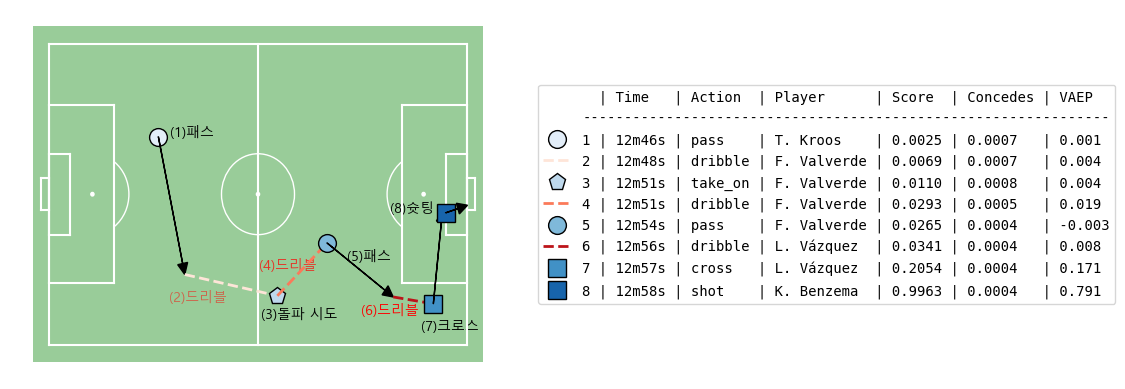

In [385]:

import matplotsoccer
import matplotlib.pyplot as plt
import matplotsoccer as mps
import matplotlib.pyplot as plt

sorted_A = A
# sorted_A = A.sort_values("vaep_value", ascending=False)
sorted_A = sorted_A[(sorted_A.time_seconds>775.0) & (sorted_A.time_seconds<780.0)]
sorted_A = sorted_A[sorted_A.game_id==3773497]
sorted_A = sorted_A[sorted_A.team_name == "Real Madrid"] # view only actions from Belgium
#sorted_A = sorted_A[~sorted_A.type_name.str.contains("shot")] #eliminate shots
#sorted_A = sorted_A[(sorted_A['scores']<0.7) & (sorted_A['concedes']<0.7)]
def get_time(period_id,time_seconds):
    m = int((period_id-1)*45 + time_seconds // 60)
    s = time_seconds % 60
    if s == int(s):
        s = int(s)
    return f"{m}m{s}s"

for j in range(0, 1):
    row = list(sorted_A[j:j+1].itertuples())[0]
    i = row.Index
    a = A[i - 5 : i+3].copy()
    
    
    result = False
    for vaep, team in zip(a['vaep_value'],a['team_name']):
        if (team !="Real Madrid"):
            result = True

    if result:
        continue
    
    a["player_name"] = a[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
    a['type_name'] = a['type_name'].replace("_"," ")
    
    for index, name in zip(a.index,a['player_name']):
        name_lst = name.split()
        first_name = name_lst[0][0] + ". "
        last_name = name_lst[-1]

        a.loc[index,'player_name'] = first_name + last_name
    
    g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
    game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name}"
    minute = int((row.period_id-1)*45 + row.time_seconds // 60)
    print(f"{game_info} {minute}' {row.type_name} {row.player_name}")

    a["scores"] = a.scores.apply(lambda x : "%.4f" % x )
    a["concedes"] = a.concedes.apply(lambda x : "%.4f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    a["time"] = a[["period_id","time_seconds"]].apply(lambda x: get_time(*x),axis=1)
    #cols = ["time", "type_name", "player_name", "team_name", "result_name","scores", "concedes","offensive_value","defensive_value","vaep_value"]
    cols = ["time", "type_name", "player_name","scores", "concedes","vaep_value"]
    t = "시간"
    # if 33273 in a.index: 
    #     a.loc[33273,'start_x'] += 1.2
    #     a.loc[33273,'start_y'] += 1.6

    matplotsoccer.actions(a[["start_x","start_y","end_x","end_y"]],
                a.type_name,
                team=a.team_name,
                result = a.result_name == "success",
                label=a[cols],
                labeltitle =  ["Time", "Action", "Player","Score", "Concedes","VAEP"],
                zoom=False,
                color="green")
   
    # for i,index in enumerate(a.index):
    #     text_name = f"({i+1}) {a.loc[index,'type_name']} \n {a.loc[index,'vaep_value']}"
    #     plt.text(a.loc[index,'start_x'],a.loc[index,'start_y'],text_name)